In [1]:
from lensing_envs.lensing_envs import Source
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ppo_continuous import Actor
import torch

Environment initialisation

In [2]:
env = Source(
    hyperparameters={
        'B':47,
        'image_x':256,
        'image_y':256,
    }
)

[ENV] Using cpu
[ENV] Seed set to 0


/home/a.shankar/.local/lib/python3.10/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading data

In [ ]:
selected_galaxies = np.load('selected_galaxies.npy')
selected_galaxies = np.mean(selected_galaxies, axis=-1, keepdims=True)
B, y, x, c = selected_galaxies.shape
selected_galaxies = np.reshape(selected_galaxies, (B, c, y, x))
selected_galaxies_min, selected_galaxies_max = selected_galaxies.min(axis=(-1,-2), keepdims=True), selected_galaxies.max(axis=(-1,-2), keepdims=True)
selected_galaxies = (selected_galaxies - selected_galaxies_min) / (selected_galaxies_max - selected_galaxies_min)

In [5]:
obs_reset, info = env.reset(selected_galaxies)

Plotting galaxy labels for reference

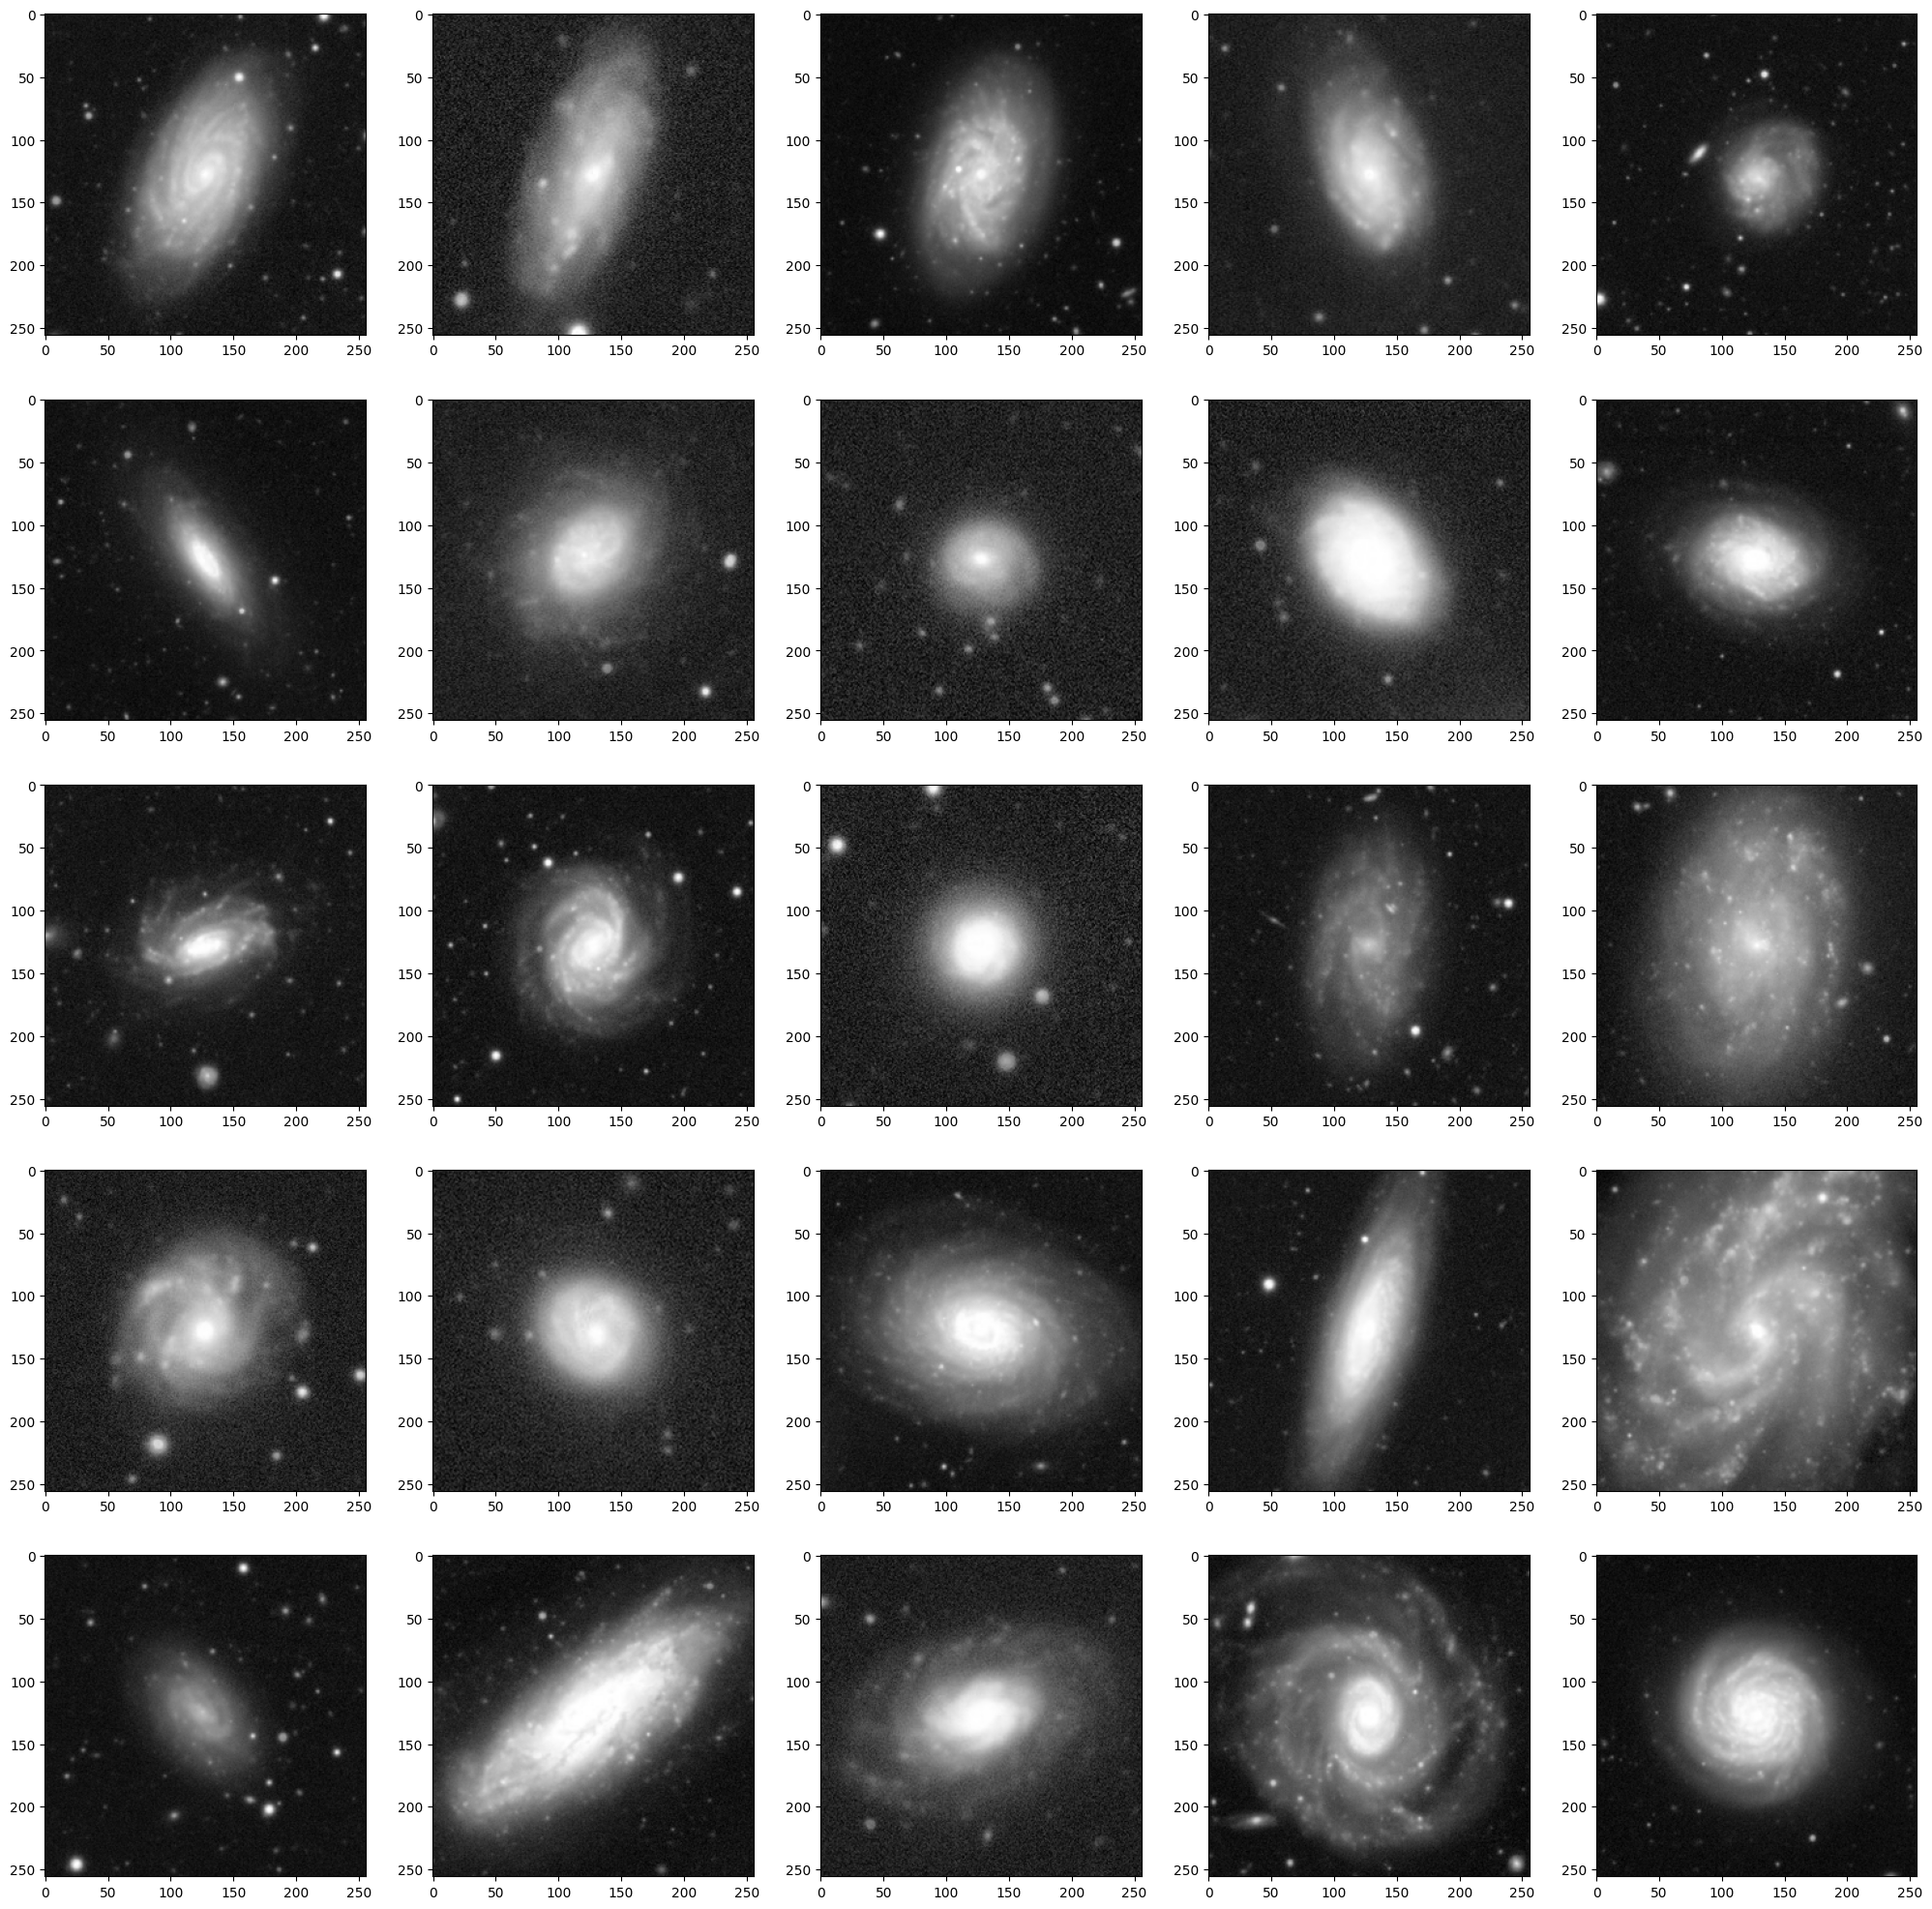

In [6]:
plot, axes = plt.subplots(5,5)
plot.set_size_inches(25,25)

i, j = 0, 0
while i < 5:
    axes[i][j].imshow(Image.fromarray(obs_reset[5*i+j,0].cpu().numpy()*255))
    j += 1
    if j == 5:
        j = 0
        i += 1

Sequentially adding the optimised Sérsics

In [ ]:
file = '5_sersic'
actions = np.load('best_actions_%s.npy'%file)
num_steps = actions.shape[0]
sersics = torch.zeros((num_steps, env.B, env.image_c, env.image_y, env.image_x))
for i in range(actions.shape[0]):
    obs, reward, _, _, info = env.step(torch.tensor(actions[i]))
    sersics[i] = info['source']
    constructed_sersics = info['sersics'].numpy()
    labels = info['labels'].numpy()
y_pred = torch.sum(sersics, dim=0)
y_pred_flat = y_pred.view(env.B, -1)
y_pred_min, _ = y_pred_flat.min(dim=-1, keepdim=True)
y_pred_max, _ = y_pred_flat.max(dim=-1, keepdim=True)
y_pred_min, y_pred_max = y_pred_min.view(env.B, 1, 1, 1), y_pred_max.view(env.B, 1, 1, 1)
y_pred = (y_pred - y_pred_min) / (y_pred_max - y_pred_min)
y_labels = env.source_labels
loss = torch.nn.functional.mse_loss(y_labels, y_pred).cpu().numpy()

constructed_sersics = torch.sum(sersics, dim=0).numpy()

Plotting each of the chosen Sérsics

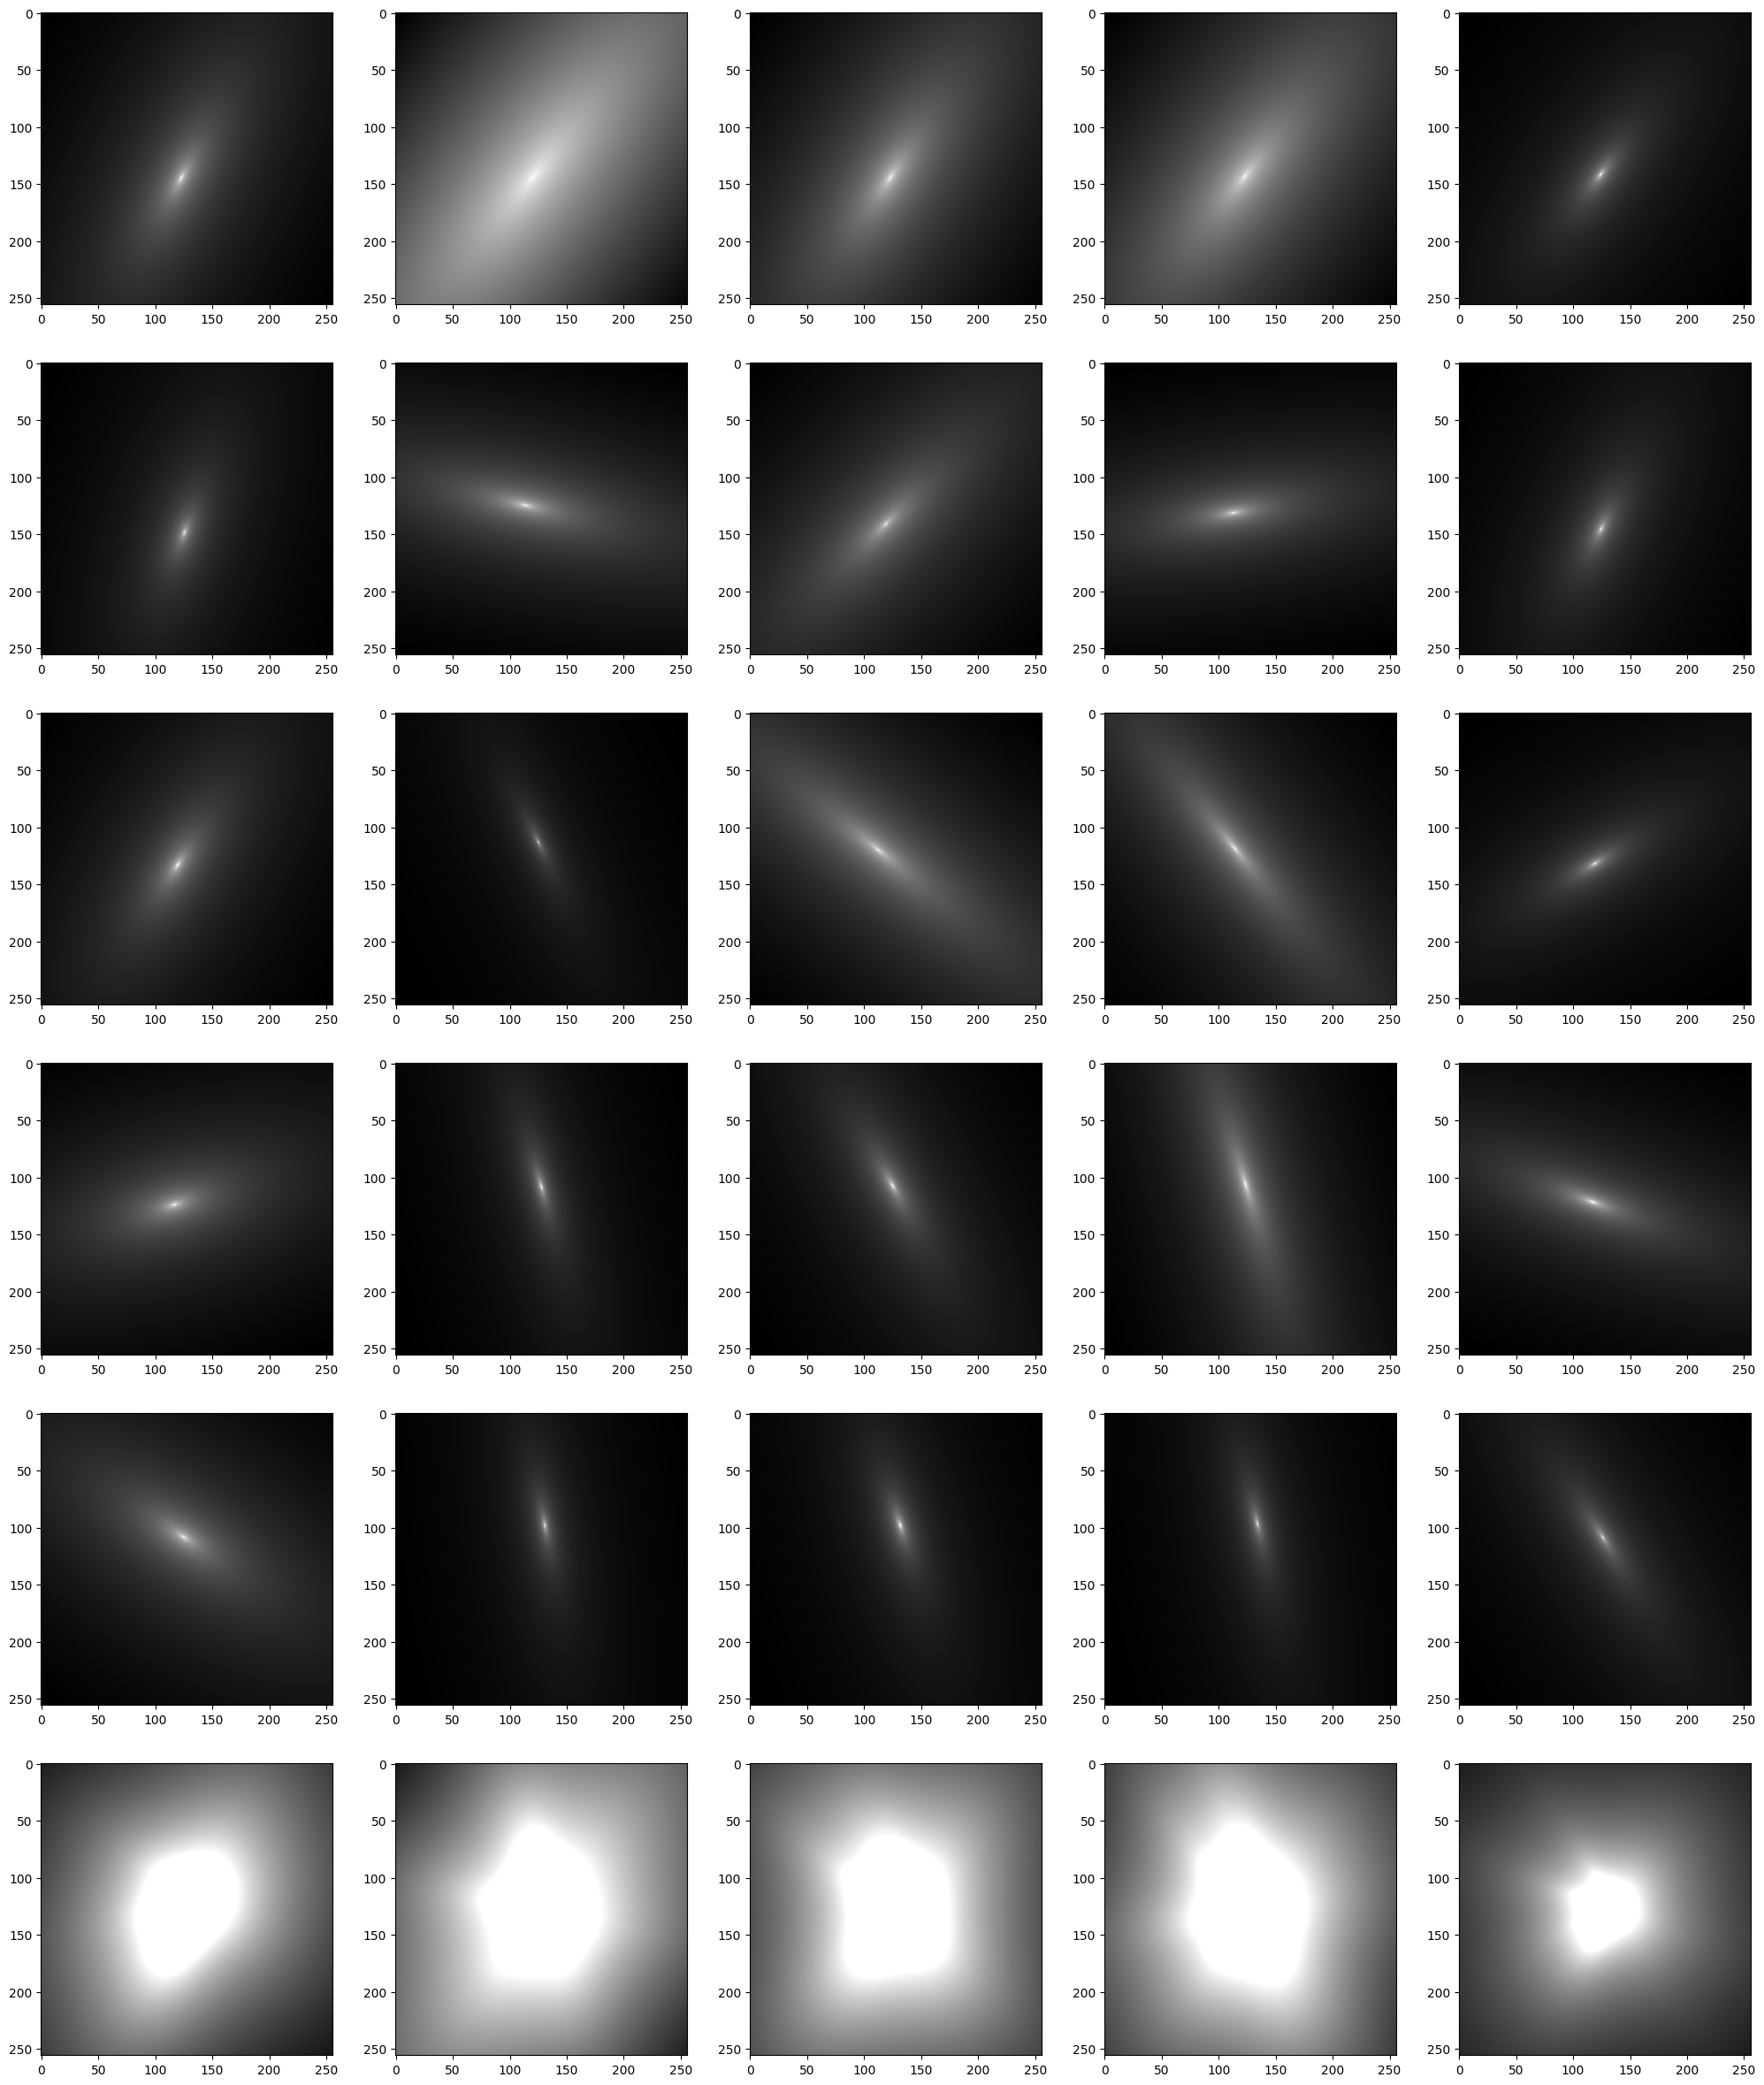

In [8]:
plot, axes = plt.subplots(num_steps+1,5)
plot.set_size_inches(25,5*(num_steps+1))

for i in range(num_steps):
    for j in range(5):
        axes[i][j].imshow(Image.fromarray(sersics[i,j,0].cpu().numpy()*255))
for j in range(5):
    axes[num_steps][j].imshow(Image.fromarray(constructed_sersics[j,0]*255))
plot.savefig('%s_composition.jpeg'%file)

Plotting the pixel-wise reconstruction loss

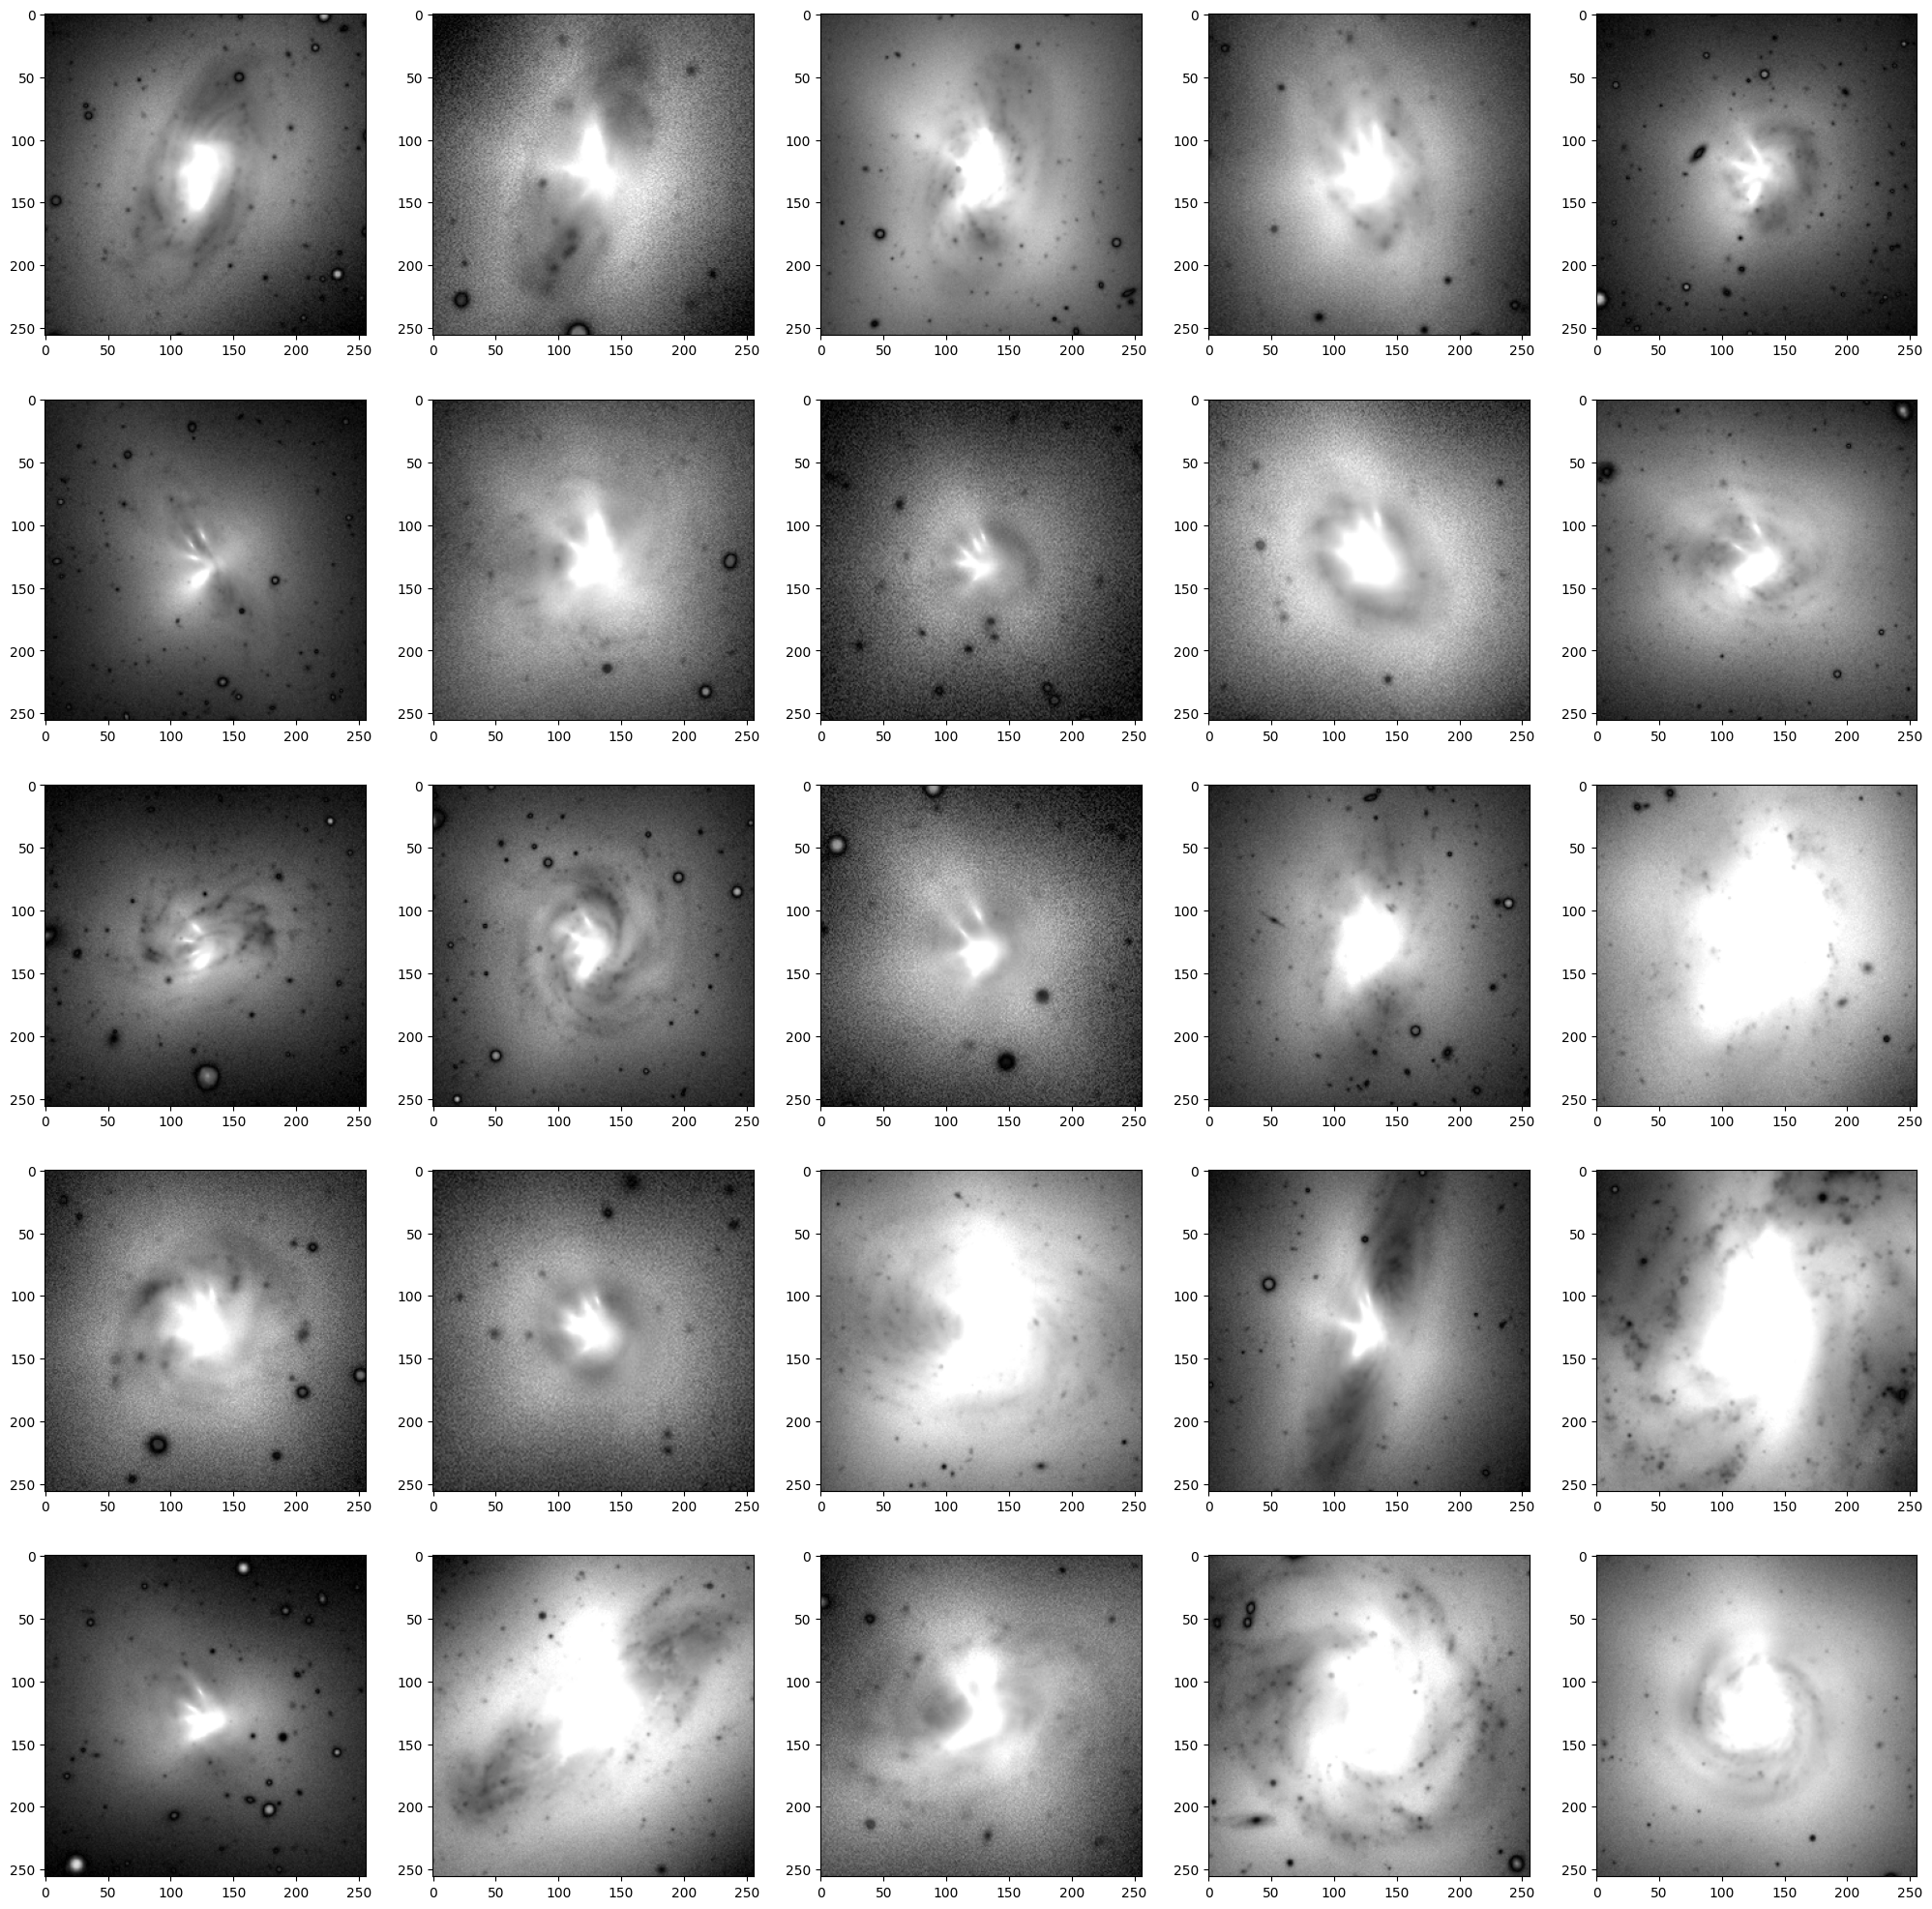

In [9]:
plot, axes = plt.subplots(5,5)
plot.set_size_inches(25,25)

i, j = 0, 0
while i < 5:
    axes[i][j].imshow(Image.fromarray(np.abs(obs[5*i+j,0].cpu().numpy())*255))
    j += 1
    if j == 5:
        j = 0
        i += 1
plot.savefig('%s_diffs.jpeg'%file)

Plotting the optimised composition of Sérsics

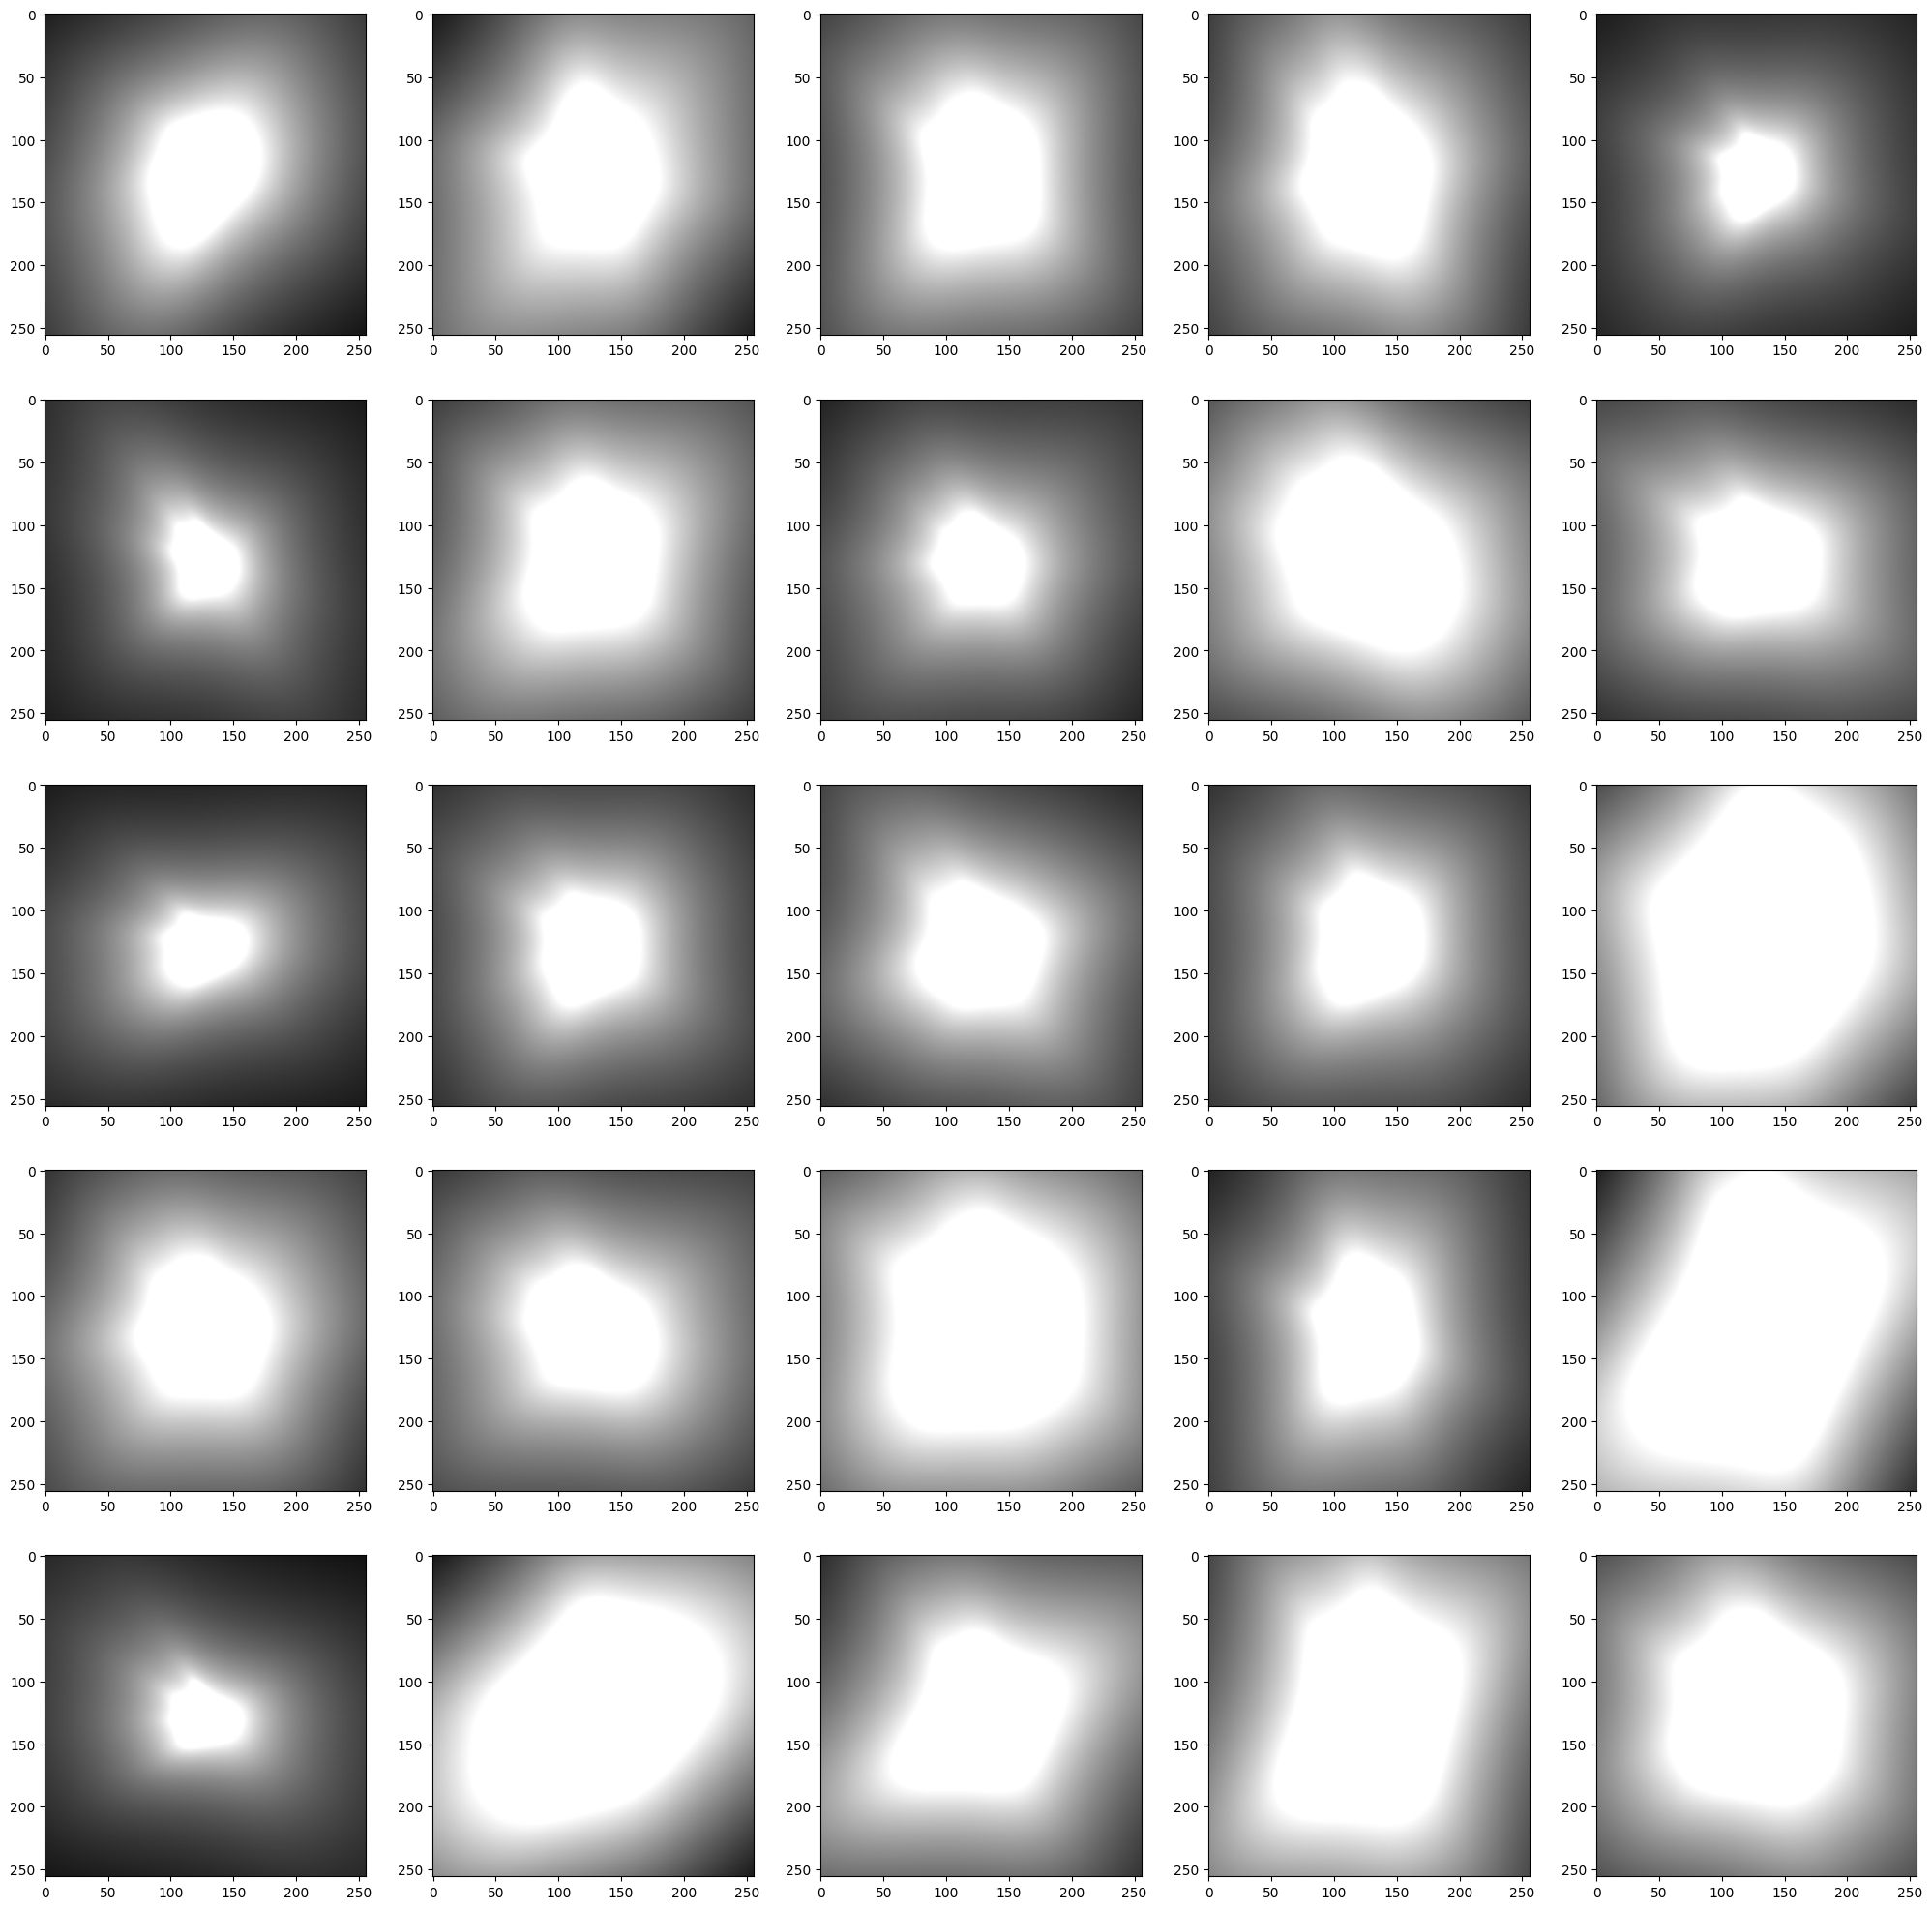

In [10]:
plot, axes = plt.subplots(5,5)
plot.set_size_inches(25,25)

i, j = 0, 0

while i < 5:
    axes[i][j].imshow(Image.fromarray(constructed_sersics[5*i+j,0]*255))
    j += 1
    if j == 5:
        j = 0
        i += 1
plot.savefig('%s.jpeg'%file)